## Linear Regression with TF Probability
### Variational vs MCMC

* Aim: comparing MCMC Simulation with Variational Bayes
* Many Ideas and the Edward code taken from https://brendanhasz.github.io/2018/12/03/tfp-regression

**This is work in progress. It (probably) requires TensorFlow 2.0 and Tensorflow Probability version 0.7**

You can use the following docker container
```
    docker pull oduerr/tf_docker:cpu_r_tfp
```


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev
TF  Version 2.0.0-alpha0


### Creation of some random data

In [58]:
#@title Synthesize dataset.
num = 20
#x = np.concatenate((np.linspace(-10,-1,num), np.linspace(1,10,num))).reshape(2*num,1)
x = np.linspace(1,10,2*num, dtype=np.float32).reshape(2*num,1)
y = np.asarray(np.random.normal(1*x[:,0]+5,np.abs(x[:,0])/3.5), dtype=np.float32)
#y = np.asarray(np.random.normal(5*x[:,0],1.0), dtype=np.float32)
x.shape, y.shape, y.dtype

((40, 1), (40,), dtype('float32'))

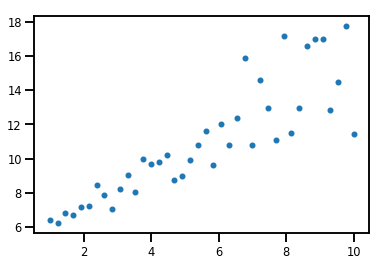

In [59]:
plt.scatter(x,y, marker='.')

In [60]:
x_test = np.linspace(-3,15, num=100).astype(np.float32) #Some x values, where we want to test
x_test = x_test[..., np.newaxis]  #Make a (100,1) Tensor
x_test_1p = x_test[0, np.newaxis] #Just take a single row

#### Training

We train using the usual max-likelihood method. I.e., we maximize the likelihood (w.r.t. the weights) that, given the data, the $y_tue$ is observed. Practically, we minimize the negative log-likelihood.

##### Definition of the likelihood

$$
  l=-\log(p_{\tt model}(y_{\tt true} | X, w))
$$

For more than one data point, we would need to sum. 

**Comment** This is a function, which compares the true label y with the output of the last layer


In [61]:
# The likelihood is simply 
#Short Version: 
#  negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# y_true the true class label 
# y_hat the output probability distribution
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

### Case 3: Epistemic Uncertainty (Specifying the uncertainties by hand)

To model the uncertainty which arises, due to the lack of data, we start a Bayesian treatment.

#### Definition of the posterior
For the posterior $𝑄(𝑤;\theta)$, we use a Gaussian approximation. For each weights and biases (n in total) a Gaussian Distribution is learned. We assume independence between the distributions for the weights and thus have 2*n parameters for $\theta$. 

In [62]:
# In more easy code
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size #Number of weights
  c = np.log(np.expm1(1.)) #Magic number for offsetting in softpuls
  
  model = tf.keras.Sequential()
  # Creating 2n variables as a starting point
  variables = tfp.layers.VariableLayer(2 * n, dtype=dtype, name='post_weights')
  model.add(variables)
  model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Independent(tfd.Normal(
          loc=t[..., :n],scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                                reinterpreted_batch_ndims=1))
      )
  return (model)


#### Definition of the prior
We also make the prior $P(W;\theta)$ trainable. We assume that it has a Gaussian-Form with fixed stddev=1 but with a trainable mu. This is called empirical Bayes.

In [63]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size

  model = tf.keras.Sequential()
  # Creating n variables as a starting point (we only learn mu)
  variables = tfp.layers.VariableLayer(n, dtype=dtype)
  model.add(variables)
  model.add(tfp.layers.DistributionLambda(lambda t: tfd.Independent(
           tfd.Normal(loc=t, scale=1),
           reinterpreted_batch_ndims=1)))
  return (model)

In [65]:
# Build model.
## Definition of the custom parametrized distribution
def my_gauss(mu):
  return tfd.Normal(loc=mu, scale=1)

inputs = tf.keras.layers.Input(shape=(1,))

prior = prior_trainable#tfd.Independent(tfd.Normal(loc=1, scale=1),reinterpreted_batch_ndims=1)

# Simple linear regression
tt = tfp.layers.DenseVariational(1, posterior_mean_field, prior)(inputs)


p_y = tfp.layers.DistributionLambda(my_gauss)(tt)
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
hist = model.fit(x, y, epochs=1000, verbose=False);

Text(0, 0.5, 'ELBO Loss')

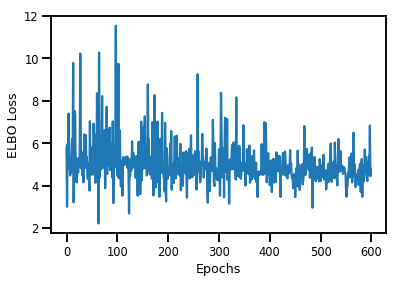

In [150]:
plt.plot(hist.history['loss'][400:])
plt.xlabel('Epochs')
plt.ylabel('ELBO Loss')

In [71]:
names = [weight.name for layer in model.layers for weight in layer.weights]
names, model.get_weights()

(['dense_variational_2/constant:0', 'dense_variational_2/constant:0'],
 [array([ 1.3229319 ,  3.2696323 , -2.1848109 , -0.40408733], dtype=float32),
  array([1.3986531, 3.1327233], dtype=float32)])

#### Sampling from the posterior

The weights of the network, follow a distribution. We can sample from the posterior by calling
```
    p = model(x_test)
    # Note that p is a distribution, with mean and std,...
    p.mean() #Sample the mean from it
```

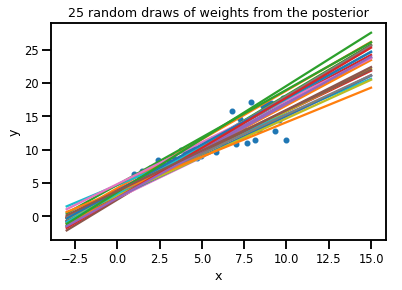

In [157]:
plt.scatter(x,y, marker='.')
plt.plot(x_test,model(x_test).mean())
for _ in range(25):
    plt.plot(x_test,model(x_test).mean(),ls='-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('25 random draws of weights from the posterior')
plt.show()

#### Averagring

Now, we average over many runs of the network. This is the same as taking the mean of the predictive distribution. 

In [73]:
mus = np.zeros(shape=(50,100))
for i in range(0,50):
    y_hat = model(x_test)
    mu = y_hat.mean()
    mus[i] = mu[:,0]

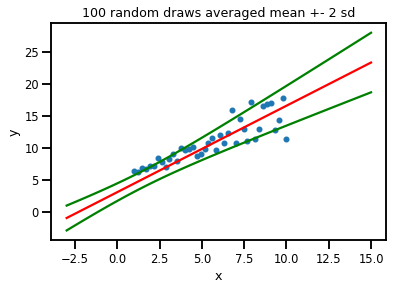

In [156]:
plt.scatter(x,y, marker='.')
m_var = np.mean(mus,axis=0)
s_var = np.std(mus, axis=0)
plt.plot(x_test,m_var, c='r')
plt.plot(x_test,m_var + 2*s_var, c='g')
plt.plot(x_test,m_var - 2*s_var, c='g')
plt.xlabel('x')
plt.ylabel('y')
plt.title('100 random draws averaged mean +- 2 sd')
plt.show()

### MCMC (with Edward)

The models can be defined using either Edward or by programming. We start with Edward.

#### Defining the model using Edward

Here we define the models generative process. Using the Distributions provided in Edward2. The Syntax seems to be:

* input the data value x
* variables with names. These names are later used to feed in the variables from the MCMC runs

In [75]:
def linear_regression(x):
  """
      features is a list containing []
  """
  D = x.shape[1]      # number of dimensions
  betas = ed.Normal(         # normal prior on weights
      loc=tf.zeros([D,1]),
      scale=tf.ones([D,1]),
      name="coeffs")   #<--- The name of these variables is important
  alphas = ed.Normal(          # normal prior on bias
      loc=tf.zeros([1]), 
      scale=tf.ones([1]),
      name="bias") 
  noise_std = ed.HalfNormal( # half-normal prior on noise std
      scale=tf.ones([1]),
      name="noise_std")
  predictions = ed.Normal(   # normally-distributed noise
      loc=tf.matmul(x, betas)+alphas,
      scale=noise_std,
      name="predictions")
  return predictions

In [76]:
from tensorflow_probability import edward2 as ed
# Joint posterior distribution
log_joint = ed.make_log_joint_fn(linear_regression)

In [77]:
log_joint

<function tensorflow_probability.python.edward2.program_transformations.make_log_joint_fn.<locals>.log_joint_fn(*args, **kwargs)>

In [78]:
def target_log_prob_fn(coeffs, bias, noise_std):
  return log_joint(
      x=x,
      coeffs=coeffs, #<-- This has to have the same name as above 
      bias=bias,
      noise_std=noise_std,
      predictions=y.reshape([len(y),1]))

In [79]:
# Defining the program
metropolis=tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=target_log_prob_fn,
    seed=54)

In [80]:
#Parameter sizes
D = 1
coeffs_size = [D,1]
bias_size = [1]
noise_std_size = [1]
current_state=[
        tf.zeros(coeffs_size, name='init_coeffs'),
        tf.zeros(bias_size, name='init_bias'),
        tf.ones(noise_std_size, name='init_noise_std'),
    ]

In [81]:
states, kernel_results = tfp.mcmc.sample_chain(
        num_results=2000,
        num_burnin_steps=100,
        kernel=metropolis,
        current_state=current_state
)
        
coeffs, bias, noise_std = states

/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [82]:
coeffs.shape, bias.shape

(TensorShape([2000, 1, 1]), TensorShape([2000, 1]))

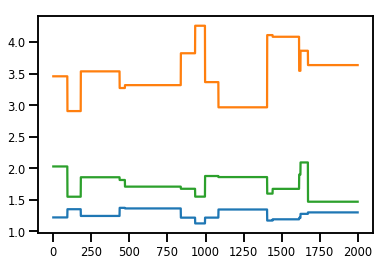

In [85]:
plt.plot(coeffs[:,0,0])
plt.plot(bias[:,0])
plt.plot(noise_std[:,0])

### MCMC

The programming is a bit tricky. Also for the data the  shapes need to be followed.

The random posterior variables which are optimized need to be lists. We create a small data set to show the shapes. To that also the shape of the y's need to be nxp.

In [86]:
w =  tf.ones([2,1], name='weights_init_state')
xs = np.array([1.,2.,3.],dtype=np.float32).reshape((3,1)) #We want the data to be with dimension Nxp
ytrues = np.array([3.,4.,5.],dtype=np.float32).reshape((3,1))

print("Shape of the weights ", w.shape)
print("Shape of the x-data  nxp", xs.shape)
print("Shape of the y-data  nx1", ytrues.shape)


Shape of the weights  (2, 1)
Shape of the x-data  nxp (3, 1)
Shape of the y-data  nx1 (3, 1)


**Attention this is a bit tricky!**
Let's keep it easy and say that we want to evaluate at three data points. In that case we draw 3 values **from the same distribution**. Let's try it the obvious but wrong way first:

In [87]:
d = tfd.Normal(loc=xs*w[0]+w[1], scale=1)
d, d.mean(), d.log_prob(ytrues).numpy()

(<tfp.distributions.Normal 'Normal/' batch_shape=(3, 1) event_shape=() dtype=float32>,
 <tf.Tensor: id=1380092, shape=(3, 1), dtype=float32, numpy=
 array([[2.],
        [3.],
        [4.]], dtype=float32)>,
 array([[-1.4189385],
        [-1.4189385],
        [-1.4189385]], dtype=float32))

### Batch-Shape vs Event Shape


TensorFlow Probability Distribution have two dimensions

(batch shape, event shape)

* Batch shape denotes a collection of Distributions with **distinct parameters**
* Event shape denotes the shape of **samples from the same** Distribution.

This result has a batch_shape of 3 and a event shape of 1. This is the absolute oposite of what we want. The batch shape of 3 corresponds to 3 independent distributions. But we want three samples of the same distribution. In that case we want 3 independent draws from the same distribution (i.i.d). We can assure that be the function `tfd.Independent` with the argument `reinterpreted_batch_ndims=1`. 

In [88]:
rv_a = tfd.Normal(loc=0., scale=10.)
d = tfd.Independent(
        tfd.Normal(loc=xs*w[0]+w[1], scale=1.0),
    reinterpreted_batch_ndims=1)
d,d.mean(), d.log_prob(ytrues).numpy(), tf.reduce_mean(d.log_prob(ytrues), axis=-1),rv_a.log_prob(w[0])


(<tfp.distributions.Independent 'IndependentNormal/' batch_shape=(3,) event_shape=(1,) dtype=float32>,
 <tf.Tensor: id=1380125, shape=(3, 1), dtype=float32, numpy=
 array([[2.],
        [3.],
        [4.]], dtype=float32)>,
 array([-1.4189385, -1.4189385, -1.4189385], dtype=float32),
 <tf.Tensor: id=1380152, shape=(), dtype=float32, numpy=-1.4189385>,
 <tf.Tensor: id=1380165, shape=(1,), dtype=float32, numpy=array([-3.2265239], dtype=float32)>)

Now the event_shape is 3 corresponding to 3 draws from the same distribution. 

A usual pattern is to write a function which takes the weights, the data (here x and y) and computes the probabiliy 

$$
    p(y|x,w) 
$$

this probability is conditioned on but not on the weight. Hence it is called joined log prob.

In [89]:
def joint_log_prob(x, y_true, w):
    
    rv_a = tfd.Normal(loc=0., scale=1.) #This is the prior for the slope and
    rv_b = tfd.Normal(loc=0., scale=1.) #intercept.
    
    #y_prob = tfd.Independent(tfd.MultivariateNormalDiag(loc=[x*w[0],w[1]], scale_diag=1.0 * tf.ones([len(w)])), reinterpreted_batch_ndims=1)
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=1.0), reinterpreted_batch_ndims=1)
    return (
         tf.reduce_mean(
             rv_a.log_prob(w[0])+
             rv_b.log_prob(w[1])+
             y_prob.log_prob(y_true), axis=-1) 
    )

In [90]:
y_prob = tfd.Independent(tfd.Normal(loc=xs*w[0] + w[1], scale=1.0), reinterpreted_batch_ndims=1)
#y_prob = tfd.Normal(loc=xs*w[0] + w[1], scale=1.0)
y_prob.mean(), y_prob.log_prob(ytrues).numpy()#, tf.reduce_mean(y_prob.log_prob(ytrues), axis=-1)

(<tf.Tensor: id=1380187, shape=(3, 1), dtype=float32, numpy=
 array([[2.],
        [3.],
        [4.]], dtype=float32)>,
 array([-1.4189385, -1.4189385, -1.4189385], dtype=float32))

We wrap this in a function of a single variable.

In [91]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w):
    #return joint_log_prob(w, xs, ytrues) #the simple smaller data set
    return joint_log_prob(x, y.reshape([len(y),1]),w) 

In [92]:
unnormalized_posterior(w)

<tf.Tensor: id=1380262, shape=(), dtype=float32, numpy=-14.904734>

In [93]:
unnormalized_posterior_2 = lambda *args: joint_log_prob(x, y.reshape([len(y),1]), *args)
unnormalized_posterior_2(w)

<tf.Tensor: id=1380324, shape=(), dtype=float32, numpy=-14.904734>

#### Doing the MCMC (Metropolis)

We do a simple random walk mcmc.

In [94]:
metropolis=tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_posterior_2,
    seed=54)

In [95]:
states, kernel_results = tfp.mcmc.sample_chain(
        num_results=400,
        num_burnin_steps=5,
        current_state = w,
        kernel=metropolis)

/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [96]:
@tf.function #Much faster, when compiling
def run_chain():
    states, kernel_results = tfp.mcmc.sample_chain(
        num_results=20000,
        num_burnin_steps=5,
        current_state = w,
        kernel=metropolis)
    return(states, kernel_results)

states, kernel_results = run_chain()

/usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


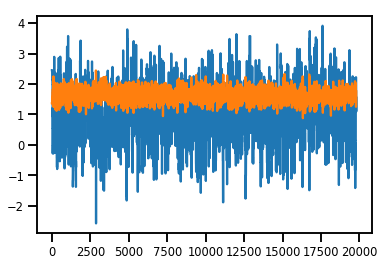

In [97]:
plt.plot(states[200:,1])
plt.plot(states[200:,0])

(1.6224012, 1.0043148, 10.941236)

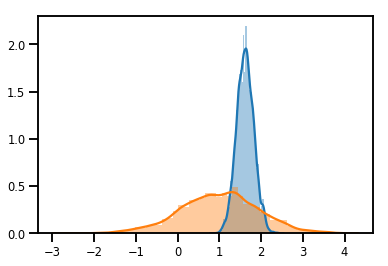

In [98]:
sns.distplot(states[200:,0], norm_hist=True, kde=True)
sns.distplot(states[200:,1], norm_hist=True, kde=True)
a_mean = np.mean(states[200:,0])
b_mean = np.mean(states[200:,1])
a_mean, b_mean, np.mean(y)

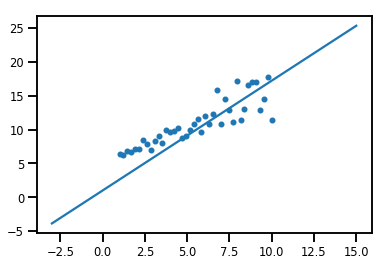

In [99]:
plt.scatter(x,y, marker='.')
plt.plot(x_test,a_mean*x_test+b_mean)

### Critisism 

In [107]:
#TODO
a_mc = states[200::10,0] #Select every 10 data point due to correlation
a_mc.shape
b_mc = states[200::10,0]
b_mc.shape, x_test.shape

(TensorShape([1980, 1]), (100, 1))

In [160]:
# Not sure if I have to add noise
y_mc = np.matmul(x_test, a_mc.numpy().transpose()) + b_mc.numpy().transpose() 
m_mc = y_mc.mean(axis=1)
s_mc = y_mc.std(axis=1)

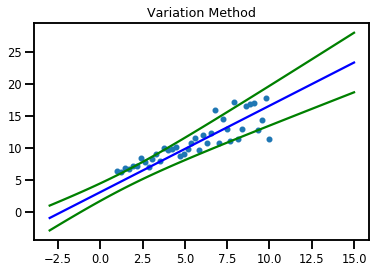

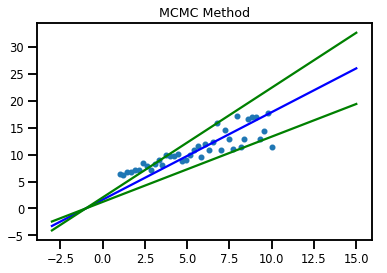

In [161]:
m_var = np.mean(mus,axis=0)
s_var = np.std(mus, axis=0)
fig, axes = plt.subplots(1, 1, sharex='all')
plt.scatter(x,y, marker='.')
plt.plot(x_test,m_var + 2*s_var, c='g')
plt.plot(x_test,m_var - 2*s_var, c='g')
plt.plot(x_test,m_var, c='b')
plt.title('Variation Method')
fig, axes = plt.subplots(1, 1, sharex='all')
plt.title('MCMC Method')
plt.scatter(x,y, marker='.')
plt.plot(x_test,m_mc, c='b')
plt.plot(x_test,m_mc + 2*s_mc, c='g')
plt.plot(x_test,m_mc - 2*s_mc, c='g')

### Other Sampler: HMC

Below is an examples of an other sampler, called Hamiltonian Monte Carlo (HMC). A HMC sampler uses gradient information to sample. It's not a random walk anymore and hence one can sample higher dimensional random variables.

In [146]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float32(.1),
  num_leapfrog_steps=2)

In [147]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

initial_state = np.zeros(1 + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

In [148]:
initial_state = np.ones(2, dtype=np.float32)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.962


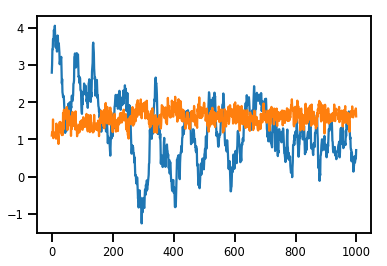

In [149]:
plt.plot(samples[:,1])
plt.plot(samples[:,0])